<a href="https://colab.research.google.com/github/Adasyam31494/Generative-AI-with-Large-Language-Models/blob/main/Image_Generation_with_PixelCNN_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow tensorflow-probability

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
tfd = tfp.distributions

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

In [6]:
def masked_conv2d(filters, kernel_size, name=None):
    return tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        padding='same',
        kernel_initializer='glorot_uniform',
        name=name,
    )

In [7]:
class PixelCNNMD(tf.keras.Model):
    def __init__(self, num_mixtures=5):
        super(PixelCNNMD, self).__init__()
        self.conv1 = masked_conv2d(64, 7, name='conv1')
        self.conv2 = masked_conv2d(64, 3, name='conv2')
        self.conv3 = masked_conv2d(64, 3, name='conv3')
        self.out_conv = tf.keras.layers.Conv2D(3 * num_mixtures * 3, 1)

        self.num_mixtures = num_mixtures

    def call(self, x):
        x = x / 255.0
        h = tf.nn.relu(self.conv1(x))
        h = tf.nn.relu(self.conv2(h))
        h = tf.nn.relu(self.conv3(h))
        out_params = self.out_conv(h)

        shape = tf.shape(out_params)
        out_params = tf.reshape(out_params, (-1, shape[1], shape[2], 3, self.num_mixtures, 3))

        loc = out_params[..., 0]
        scale = tf.nn.softplus(out_params[..., 1]) + 1e-3
        logits = out_params[..., 2]

        logistic = tfd.Logistic(loc=loc, scale=scale)
        mixture_dist = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(logits=logits),
            components_distribution=logistic
        )
        return mixture_dist

In [8]:
model = PixelCNNMD(num_mixtures=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [9]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        dist = model(images)
        loss = -tf.reduce_mean(dist.log_prob(images / 255.0))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [10]:
epochs = 5
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)

losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0.0
    steps = 0
    for batch in train_dataset:
        loss = train_step(batch)
        epoch_loss += loss.numpy()
        steps += 1
    avg_loss = epoch_loss / steps
    print(f"Loss: {avg_loss}")
    losses.append(avg_loss)

Epoch 1/5
Loss: -1.1113756895065308
Epoch 2/5
Loss: -2.0014488697052
Epoch 3/5
Loss: -2.451601028442383
Epoch 4/5
Loss: -2.609545946121216
Epoch 5/5
Loss: -2.9153575897216797


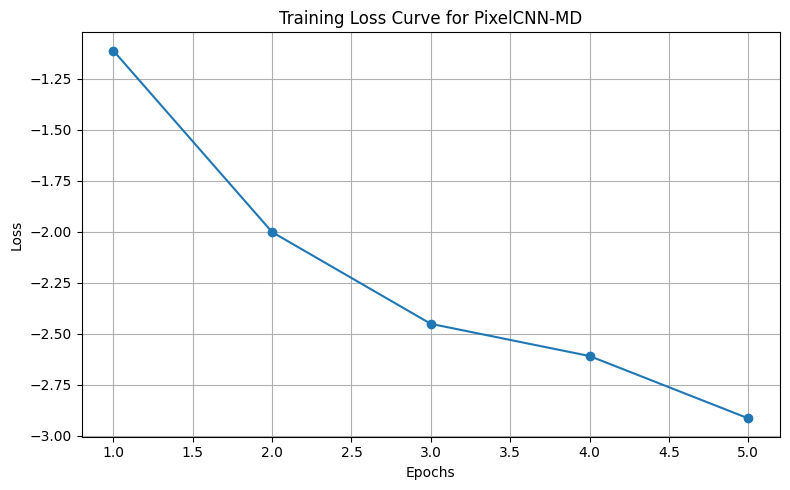

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title('Training Loss Curve for PixelCNN-MD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.savefig("Figure_1_Training_Loss_Curve_PixelCNN_MD.png")
plt.show()

In [13]:
@tf.function
def generate_sample():
    samples = tf.zeros((1, 32, 32, 3), dtype=tf.float32)

    for i in tf.range(32):
        for j in tf.range(32):
            dist = model(samples)
            pixel = dist.sample()[:, i, j, :]  # shape: (1, 3)
            # Update full RGB pixel: shape must match
            update = tf.reshape(pixel, (1, 1, 1, 3))  # shape: (1, 1, 1, 3)
            mask = tf.tensor_scatter_nd_update(
                tf.zeros_like(samples), [[0, i, j]], tf.ones((3,))
            )
            samples = samples * (1 - mask) + update * mask

    return tf.clip_by_value(samples, 0.0, 1.0)

In [14]:
model.build(input_shape=(None, 32, 32, 3))
model.summary()

Model: "pixel_cnnmd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (64, 32, 32, 64)       │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (64, 32, 32, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (64, 32, 32, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (64, 32, 32, 45)       │         2,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,253 (336.93 KB)

 Trainable params: 86,253 (336.93 KB)

 Non-trainable params: 0 (0.00 B)